Animating discharge into the Salish Sea Atlantis grid by ships fitted with scrubbers.

In [13]:
import os
import xarray as xr
import numpy as np
from datetime import datetime
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
# Salish Sea Atlantis Shapefile.
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(shapefile_name)
data_df = data_df.sort_values(by=['BOX_ID'])
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]


In [ ]:
# Reading in the file generated by Ocean Parcels

release_start = '2020-01-19'
parcelsFileName = 'results/5b_Turn_Point_Diluted_bitumen2020-01-19_OP.nc'

pfile = xr.open_dataset(str(parcelsFileName), decode_cf=True)

lon = np.ma.filled(pfile.variables['lon'], np.nan)
lat = np.ma.filled(pfile.variables['lat'], np.nan)
#time = np.ma.filled(pfile.variables['time'], np.nan)

numParticles = lon.shape[0]
print(numParticles)

100


In [ ]:
# Defining particle dispersion period

trackDates = []

for i in range(0,numParticles):
    #print(time[i][0])
    trackDates.append(time[i][0])

RDiff = (max(trackDates) - min(trackDates))

minDate = np.datetime64(release_start+"T00:30:00")
#outputDT = 60*60 #1 hour
outputDT = 43200.00

stepsPerDay = int(86400.0/ outputDT)

numStepsPerDT = int(outputDT/3600.0)
trackLength = len(lon[0])
numReleaseDays = RDiff

numReleaseDTS = int(abs(numReleaseDays/np.timedelta64(1, 'h')))
totalNumOfTS = int(numReleaseDTS + trackLength)
#print('total number of time steps = ' + str(totalNumOfTS))
#print('track length = ' + str(trackLength))

In [ ]:
trackLonsPadded = np.zeros((int(numParticles), totalNumOfTS))
trackLatsPadded = np.zeros((int(numParticles), totalNumOfTS))
particlesAge = np.zeros((int(numParticles), totalNumOfTS))

for trackIndex in range(0,numParticles):
    trackDateDiff = trackDates[trackIndex] - minDate
    trackNumsToPad = int(trackDateDiff/np.timedelta64(1, 'h'))
    
    trackLonsPadded[trackIndex][0:trackNumsToPad] = 0
    trackLatsPadded[trackIndex][0:trackNumsToPad] = 0

    trackLonsPadded[trackIndex][trackNumsToPad:trackNumsToPad + trackLength] = lon[:][trackIndex]
    trackLatsPadded[trackIndex][trackNumsToPad:trackNumsToPad + trackLength] = lat[:][trackIndex]

numSteps = int(trackLength / numStepsPerDT)

In [4]:
# Reading in Atlantis-specific files

Atlantis_FileName = 'Atlantis_Scrubber_PAH_2019.nc'
savefile_prefix = 'boxes'

afile = xr.open_dataset(str(Atlantis_FileName), decode_cf=False, decode_times=True)

time = np.ma.filled(afile.variables['t'], np.nan)
PAH_all = np.ma.filled(afile.variables['Phenanthrene']) 

print(PAH_all.shape)
num_steps = time.shape[0]
print(num_steps)

(730, 130, 7)
730


Text(0, 0.5, 'mg PAHphe / m^3')

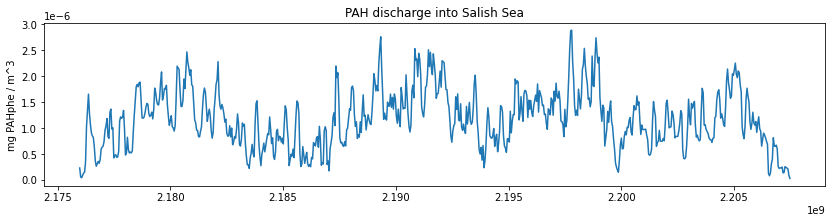

In [5]:
PAH_surface = PAH_all.sum(axis=2)
fig, ax = plt.subplots(figsize = (14,3))
ax.plot(time, PAH_surface.sum(axis=1))
ax.set_title('PAH discharge into Salish Sea')
ax.set_ylabel('mg PAHphe / m^3');

In [ ]:
# Uncomment below ff adding a log scale so the boxes show the proportion of contamination
# import matplotlib.colors as colors

_cmap = cm.binary
file_names = []

land_df = data_df.loc[land_boxes]

for time_index in range(0, 5):#num_steps):
    
    ts_date = str(time[time_index])
    time_oil = PAH_surface[time_index]
    data_df['oil'] = time_oil
    data_df.loc[land_boxes, 'oil'] = 0

    fig = plt.figure(figsize=(9, 15), facecolor='white')
    ax = fig.add_subplot(1,1)
    ax = data_df.plot(column = 'oil', cmap=_cmap, facecolor='white',
        #norm=colors.SymLogNorm(#linthresh=0.001, linscale=0.0000001,
        #vmin=-0.00001, vmax=0.00001, #base=10),
        vmin=-0.0000002, vmax=0.000001,
        legend=True, legend_kwds={'label': "Relative PAH"
        },)
    land_df.plot(ax=ax, color='white')
    data_df.boundary.plot(ax=ax, color="grey", linewidths=0.7)
    ax.set_title(ts_date)

    #plt.tight_layout()
    plot_name = savefile_prefix + '_time_' + str(time_index).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("*.png")
imgs.sort() 
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)


# Save into loop
anim_name = 'ScrubberDischarge2019.gif'
frames[0].save(anim_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

file_name_str = ' '.join(file_names)
os.system('rm ' + file_name_str)

# Display the animation
from IPython.display import Image
with open(anim_name,'rb') as anim:
    display(Image(anim.read()))
